Notes:

    1. Check transformer score over syth data with high noise
    2. Check transformer score over real geology data.

# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import sys, os
sys.path.append("../..")

## Import pytorch libs

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
from IPython.display import clear_output

## Import data libs

In [3]:
from data.SythData import SinusoidWaves, LinearSteps
from data.CloudData import DrillingData
from sklearn.preprocessing import normalize

# Load Trained Transformer CPD model

## Define path

In [4]:
path_to_transformer = "../../models/transfomer_cpd_large_syth_data.pt"

## Load with jit

In [5]:
cpd_transformer_naive = torch.jit.load(path_to_transformer)

# Define Data Transformer

Notes:

    1. sequence len should be set 50
    2. data has to be normalized ?!
    3. data should be tensor type

In [6]:
class PreprocessData:
    def __init__(self,
        ts,
        cps,
        sample_len):
        
        self.ts = ts
        self.cps = cps
        self.sample_len = sample_len

    def count_data(self) -> int:
        return self.ts.shape[0] // self.sample_len

    def divide_remainder_value(self) -> int:
        return self.ts.shape[0] % self.sample_len

    def generate_outer_ts_sample_on_remainder_value(self) -> list[int]:
        remainder_value = self.divide_remainder_value()
        out_sample_array = list(self.ts[-remainder_value:])
        zero_list = [0 for i in range(abs(remainder_value - self.sample_len))]
        return out_sample_array + zero_list

    def generate_outer_cps_sample_on_remainder_value(self) -> list[int]:
        remainder_value = self.divide_remainder_value()
        out_sample_array = list(self.cps[-remainder_value:])
        zero_list = [0 for i in range(abs(remainder_value - self.sample_len))]
        return out_sample_array + zero_list

    # def replace_all_zero_to_low_value(self, x) -> np.array:
    #     return [1e-5 if i == 0 else i for i in x]

    def extract_y_array(self, df: pd.DataFrame) -> np.array:
        # extract CPs values and split it by sample size vector
        array = df['y'].values
        return np.array([array[i*self.sample_len:i*self.sample_len+self.sample_len] for i in range(int(array.shape[0]/self.sample_len))])

    def extract_x_array(self, df: pd.DataFrame) -> np.array:
        # extact raw values and split it by sample size vector
        array = df['x'].values
        return np.array([array[i*self.sample_len:i*self.sample_len+self.sample_len] for i in range(int(array.shape[0]/self.sample_len))])


    def transform(self) -> pd.DataFrame:
        df = pd.DataFrame()
        if self.divide_remainder_value() != 0:
            ts_transformed = list(self.ts) + self.generate_outer_ts_sample_on_remainder_value()
            cps_transformed = list(self.cps) + self.generate_outer_cps_sample_on_remainder_value()
        else:
            ts_transformed = list(self.ts)
            cps_transformed = list(self.cps)
        df['y'] = cps_transformed
        df['x'] = normalize([np.array(ts_transformed)])[0]

        array_x = self.extract_x_array(df)
        array_y = self.extract_y_array(df)
        
        return torch.Tensor(array_x), torch.Tensor(array_y)

# Load Data

## define list of possible data

In [7]:
list_of_drilling_data_names = ["229G", "231G", "237G", "xxxAA684G", "xxxAA564G"]

## load raw-processed datasets

In [8]:
df_0 = DrillingData(dataset_name="229G").get()

In [9]:
df_1 = DrillingData(dataset_name="231G").get()

In [10]:
df_2 = DrillingData(dataset_name="237G").get()

In [11]:
df_3 = DrillingData(dataset_name="xxxAA684G").get()

In [12]:
df_4 = DrillingData(dataset_name="xxxAA564G").get()

## extract features 1D time-series and target CPs

In [13]:
def generate_cp_based_on_rock_types(array_of_rocks_types: np.array) -> np.array:
    dp = np.zeros_like(array_of_rocks_types)
    first_type: int = array_of_rocks_types[0]
    for indx, val in enumerate(array_of_rocks_types):
        if first_type != val:
            dp[indx] = 1
            first_type = val
    return dp

def extract_from_number_g(df: pd.DataFrame) -> tuple:
    """ Only for ***G case.
    """
    x = df["GR"].values
    y = df["CPs"].values
    return x, y

def extract_from_number_xxx(df: pd.DataFrame) -> tuple:
    """ Only for xxxAA***G case.
    """
    df.replace(to_replace = -9999 , value=np.NaN, regex = True, inplace=True)
    df.dropna(thresh=15, inplace=True)
    df.reset_index(drop=True, inplace=True)
    x = df["uR/h"].values
    y = generate_cp_based_on_rock_types(df["unitless"].values)
    return x, y
    

In [14]:
list_of_data = []
for i in [df_0, df_1, df_2]:
    list_of_data.append(extract_from_number_g(i))
for i in [df_3, df_4]:
    list_of_data.append(extract_from_number_xxx(i))

# Data preprocessing

In [15]:
list_of_preprocessed_data = [PreprocessData(ts=val[0], cps=val[1], sample_len=50).transform() for val in list_of_data]

In [16]:
list_of_preprocessed_data[-1][1].shape #targets

torch.Size([176, 50])

In [17]:
list_of_preprocessed_data[-1][0].shape #raw values

torch.Size([176, 50])

# Model Inference

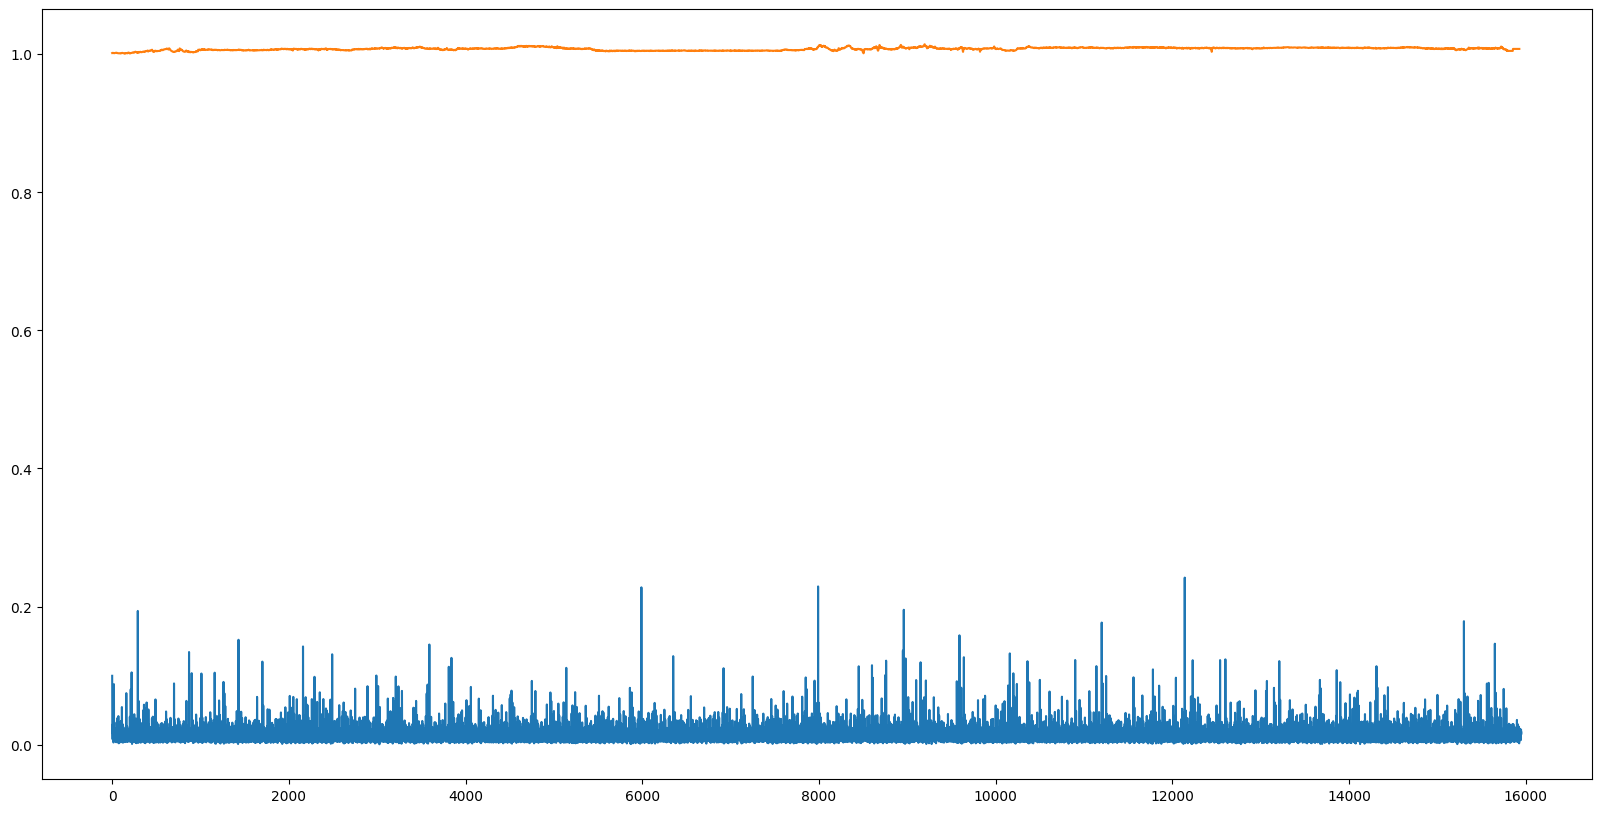

In [25]:
plt.figure(figsize=(20,10))
plt.plot(cpd_transformer_naive(list_of_preprocessed_data[2][0]).flatten().detach().numpy())
# plt.plot(list_of_data[2][1])
plt.plot((normalize([df_2['GR'].values])+1)[0])

In [28]:
preds = cpd_transformer_naive(list_of_preprocessed_data[2][0]).flatten().detach().numpy()

In [32]:
def transform_preds(preds: np.array, threshold: float = 0.2, val_plot: int = 1) -> np.array:
    return np.array([1*val_plot if i > threshold else 0 for i in preds]) 

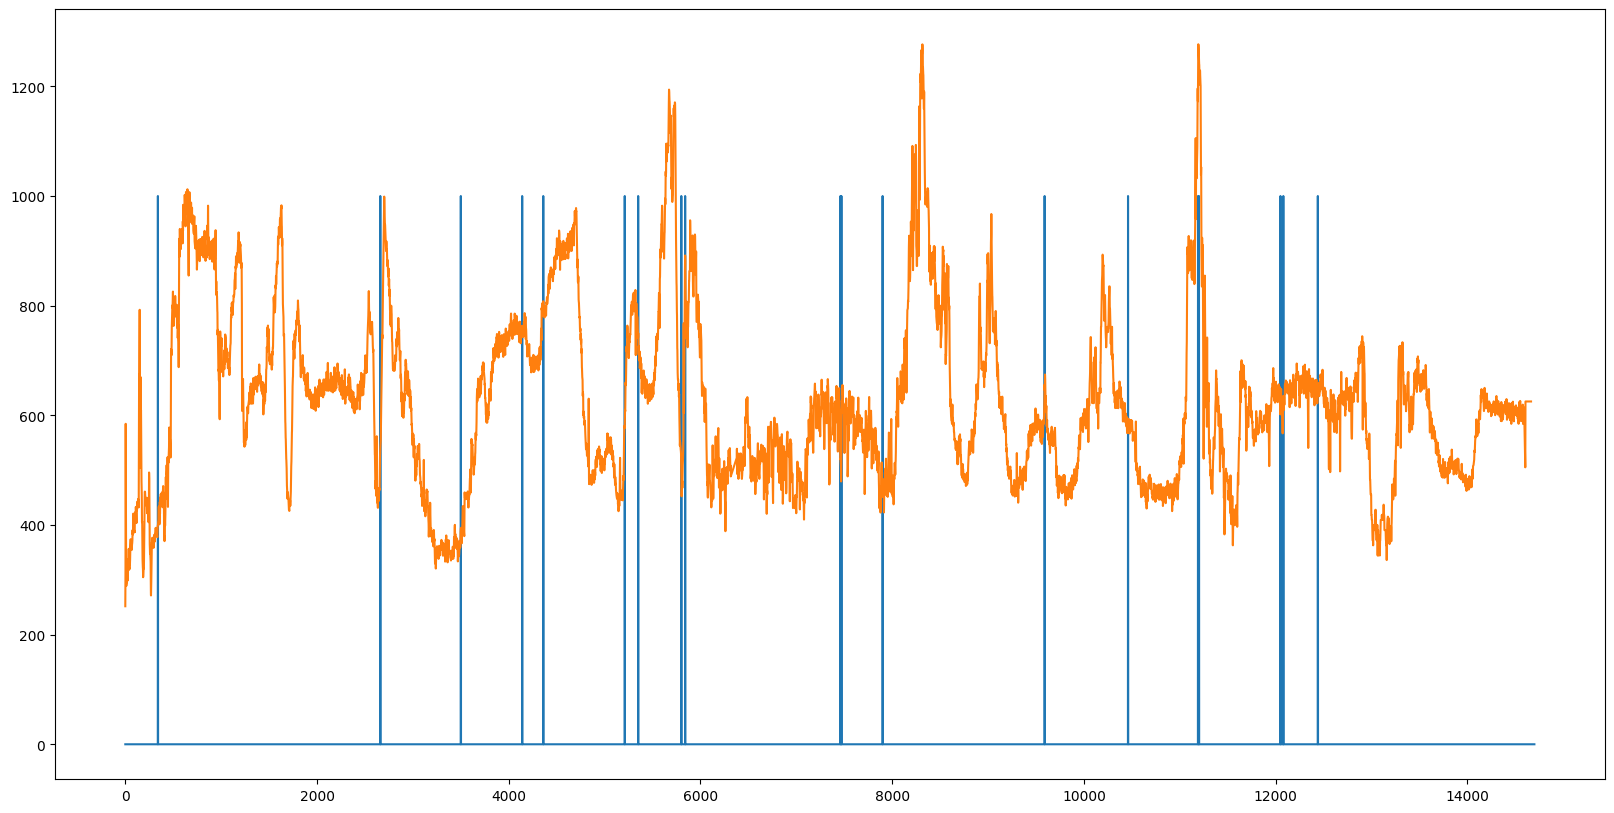

In [45]:
plt.figure(figsize=(20,10))
plt.plot(transform_preds(cpd_transformer_naive(list_of_preprocessed_data[1][0]).flatten().detach().numpy(), 0.15, 1000))
plt.plot(df_1['GR'].values)